# Urban Simulation Crime Modeling Exercise

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import choice, randint, shuffle, choices
from scipy.stats import linregress
from scipy.stats import f_oneway

# loads model parameters
params = pd.read_csv("/Users/noamgal/Downloads/crime_model_parameters.csv")
print(params.head())

   residents_num   criminal_num   grid_shape1  grid_shape2
0             180             20           10           10
1             180             20           30           30
2             180             20           50           50
3             160             40           10           10
4             160             40           30           30


In [3]:
# import relevant functions for drawing random values
from random import choice, randint, shuffle


class Cell:
    def __init__(self, x, y): # inputs - coordinates
        self.x = x
        self.y = y
        
        self.agents = [] # stores agents located within the cell
        self.crimes = 0 # tracks the number of crimes committed in the cell


class Agent:
    def __init__(self, a_type, cell, budget):
        '''inputs:
            a_type (str): type of agent - resident/criminal,
            cell (Cell object): cell in which the agent starts the simulation
            budget (int): resources at the disposal of the agent
            '''
        self.a_type = a_type
        self.cell = cell
        self.budget = budget
        
        cell.agents.append(self) # locate agent inside the cell
    
    def resident_step(self):
        '''step method for resident agents - moves to a random new cell'''
        self.budget += 1 # resources increase with every step
        new_cell = self.cell # set current cell as new cell
        while new_cell == self.cell: # loop to make sure a new cell is selected
            new_cell = choice(choice(model.grid)) # randomly choose an array and a cell from the array
        return new_cell
        
    
    def criminal_step(self):
        '''step method for criminal agents - 
        move to a random cell, randomly select an agent and steal 1 resource point'''
        new_cell = self.cell # set current cell as new cell
        while new_cell == self.cell: # loop to make sure a new cell is selected
            new_cell = choice(choice(model.grid)) # randomly choose an array and a cell from the array
            
        if new_cell.agents: # if there are any agents in the cell (empty list==False)
            agent = choice(new_cell.agents) # randomly choose an agent present in the cell
            if agent.budget > 0: # if the agent has any resources - steal one unit
                agent.budget -= 1 # remove one unit of resources from selected agent
                self.budget += 1 # add one unit to current agent
                new_cell.crimes += 1 # increase the new cell's crime counter
    
        return new_cell
    
    def step(self):
        '''General step method for both types of agents:
            locates new cell and makes the required changes'''
        if self.a_type == 'resident': # check agent type and activate step method
            new_cell = self.resident_step()
        else:
            new_cell = self.criminal_step()
        
        self.cell.agents.remove(self) # remove current agent from current cell
        new_cell.agents.append(self) # add current agent to new cell
        self.cell = new_cell # move current agent to new cell
        

class Model:
    def __init__(self, residents_num, criminal_num, grid_shape):
        '''inputs: residents_num (int) - number of resident agents,
        criminal_num (int) - number of criminal agents,
        grid_shape (container of two int items) - number of grid rows and columns'''
        self.grid_shape = grid_shape
        
        # create a 2D array of Cell objects
        self.grid = [[Cell(x, y) for y in range(grid_shape[1])] for x in range(grid_shape[0])] 
        # create a 1d Array of Agent objects  (length==resident_num) located in a random cell and with a random budget
        self.residents = [Agent('resident', choice(choice(self.grid)), randint(10, 50)) for i in range(residents_num)]
        # create a 1d Array of Agent objects  (length==criminal_num) located in a random cell and with budget==1
        self.criminals = [Agent('criminal', choice(choice(self.grid)), 1) for i in range(criminal_num)]
    
    def simulate(self):
        '''Run 30 iterations and return the total number of crimes, maximal number of crimes per cell,
        and percent of cells where no crimes were registered througout the simulation'''
        for i in range(30):
            agents = self.residents + self.criminals # merge the lists of agents into one
            shuffle(agents) # randomly reorder the merged list
            for agent in agents: # execute step function per agent
                agent.step()
        
        # generate outputs - get the count of crimes per cell
        crimes = [self.grid[x][y].crimes for x in range(self.grid_shape[0]) for y in range(self.grid_shape[1])]
        total_crimes = sum(crimes) # total number of crimes committed throughout the simulation
        max_crimes = max(crimes) # get the counter value for the cell with the most crimes committed
        # compute the percent of cells where no crime was committed
        no_crimes = 100 * len([c for c in crimes if c==0]) / (self.grid_shape[0] * self.grid_shape[1])
        return(total_crimes, max_crimes, no_crimes)

In [4]:
# dataframe to save outputs
outputs_avg = pd.DataFrame(columns = {
    'Total crimes':[],
    'Maximum crimes':[],
    '% crime-free cells':[]
})

In [5]:
for n, row in params.iterrows():
    total = []
    maximum = []
    percent = []
    for r in range(5):
        model = Model(row[0], row[1],(row[2], row[3]))
        results = model.simulate()
        total.append(results[0])
        maximum.append(results[1])
        percent.append(results[2])
    outputs_avg.loc[len(outputs_avg)] = [np.mean(total),np.mean(maximum),np.mean(percent)]

In [6]:
print(outputs_avg)

   Total crimes  Maximum crimes  % crime-free cells
0         520.6            13.0            0.800000
1         118.2             2.2           87.955556
2          46.8             1.2           98.136000
3        1044.4            20.4            0.000000
4         237.2             3.4           78.155556
5          96.6             2.2           96.248000
6        1564.4            27.6            0.000000
7         358.6             4.4           68.533333
8         142.0             2.0           94.592000


In [7]:
effects = pd.concat([params, outputs_avg], axis=1)

# replace string in the below function with a folder and file name for your PC

# Remove extra space from column names
effects.columns = effects.columns.str.strip()

# Combine the two grid_shape columns into a new column
effects['total_grid_shape'] = effects['grid_shape1'] + effects['grid_shape2']

# drop old grid shape columns 
effects.drop(columns=['grid_shape1', 'grid_shape2'], inplace=True)

print(effects)
#effects.to_csv('file-loc-on-your-computer')

   residents_num  criminal_num  Total crimes  Maximum crimes  \
0            180            20         520.6            13.0   
1            180            20         118.2             2.2   
2            180            20          46.8             1.2   
3            160            40        1044.4            20.4   
4            160            40         237.2             3.4   
5            160            40          96.6             2.2   
6            140            60        1564.4            27.6   
7            140            60         358.6             4.4   
8            140            60         142.0             2.0   

   % crime-free cells  total_grid_shape  
0            0.800000                20  
1           87.955556                60  
2           98.136000               100  
3            0.000000                20  
4           78.155556                60  
5           96.248000               100  
6            0.000000                20  
7           68.533333  

In [10]:
# Define the input parameters and outcome variables
input_params = ['residents_num', 'criminal_num', 'total_grid_shape']
outcome_vars = ['Total crimes', 'Maximum crimes', '% crime-free cells']

# Print the first few rows of the DataFrame
print(effects.head())


   residents_num  criminal_num  Total crimes  Maximum crimes  \
0            180            20         520.6            13.0   
1            180            20         118.2             2.2   
2            180            20          46.8             1.2   
3            160            40        1044.4            20.4   
4            160            40         237.2             3.4   

   % crime-free cells  total_grid_shape  
0            0.800000                20  
1           87.955556                60  
2           98.136000               100  
3            0.000000                20  
4           78.155556                60  


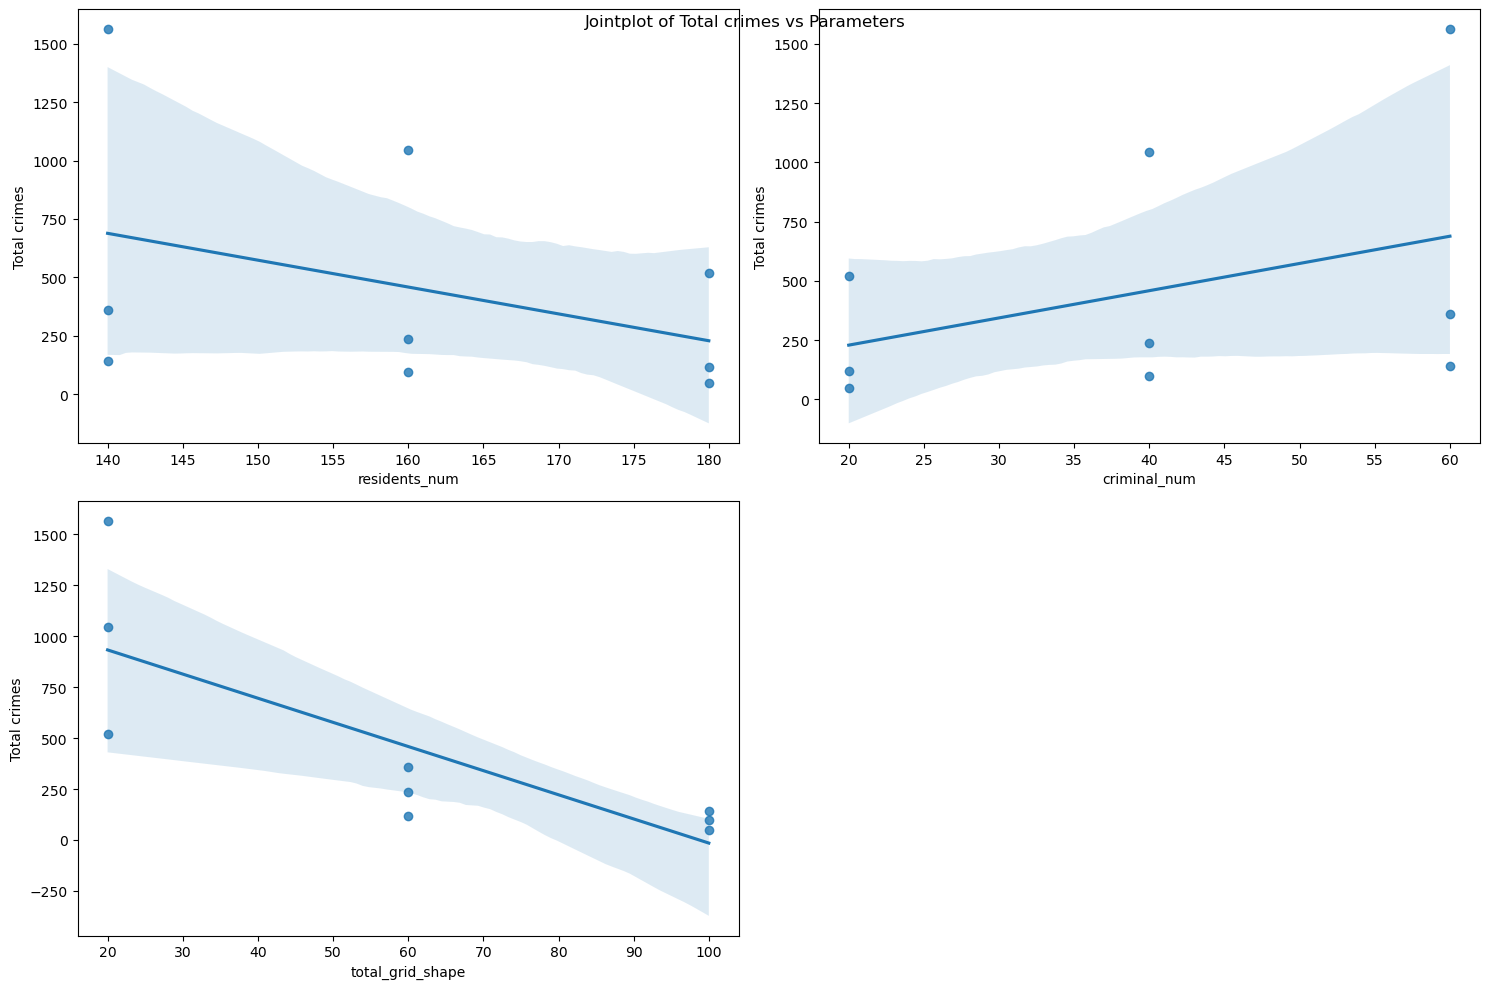

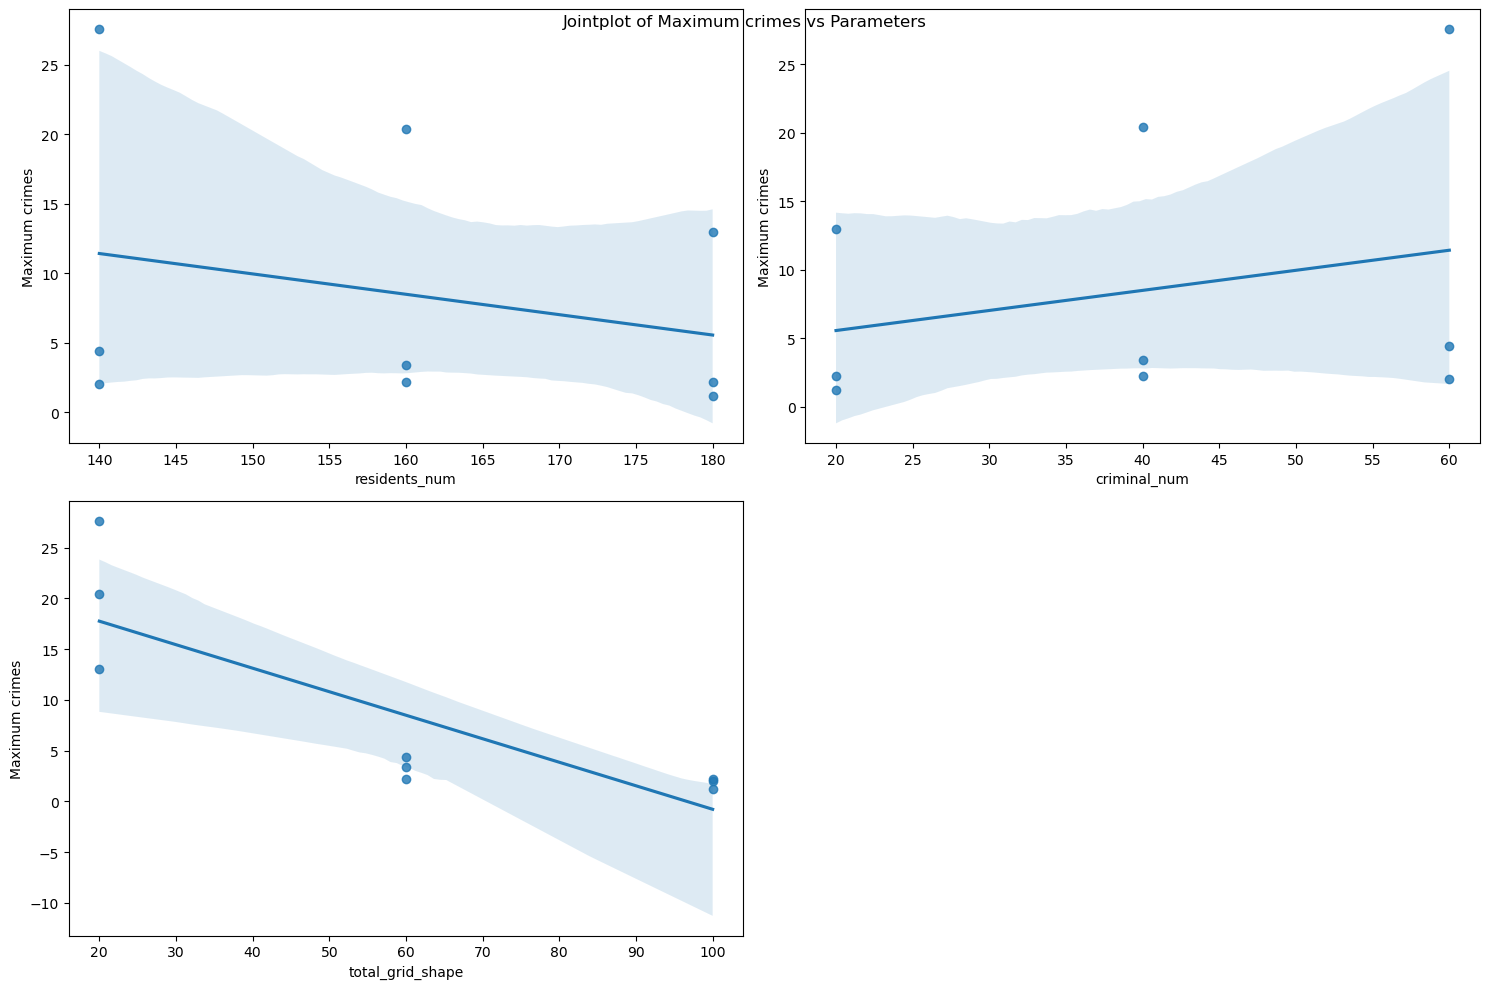

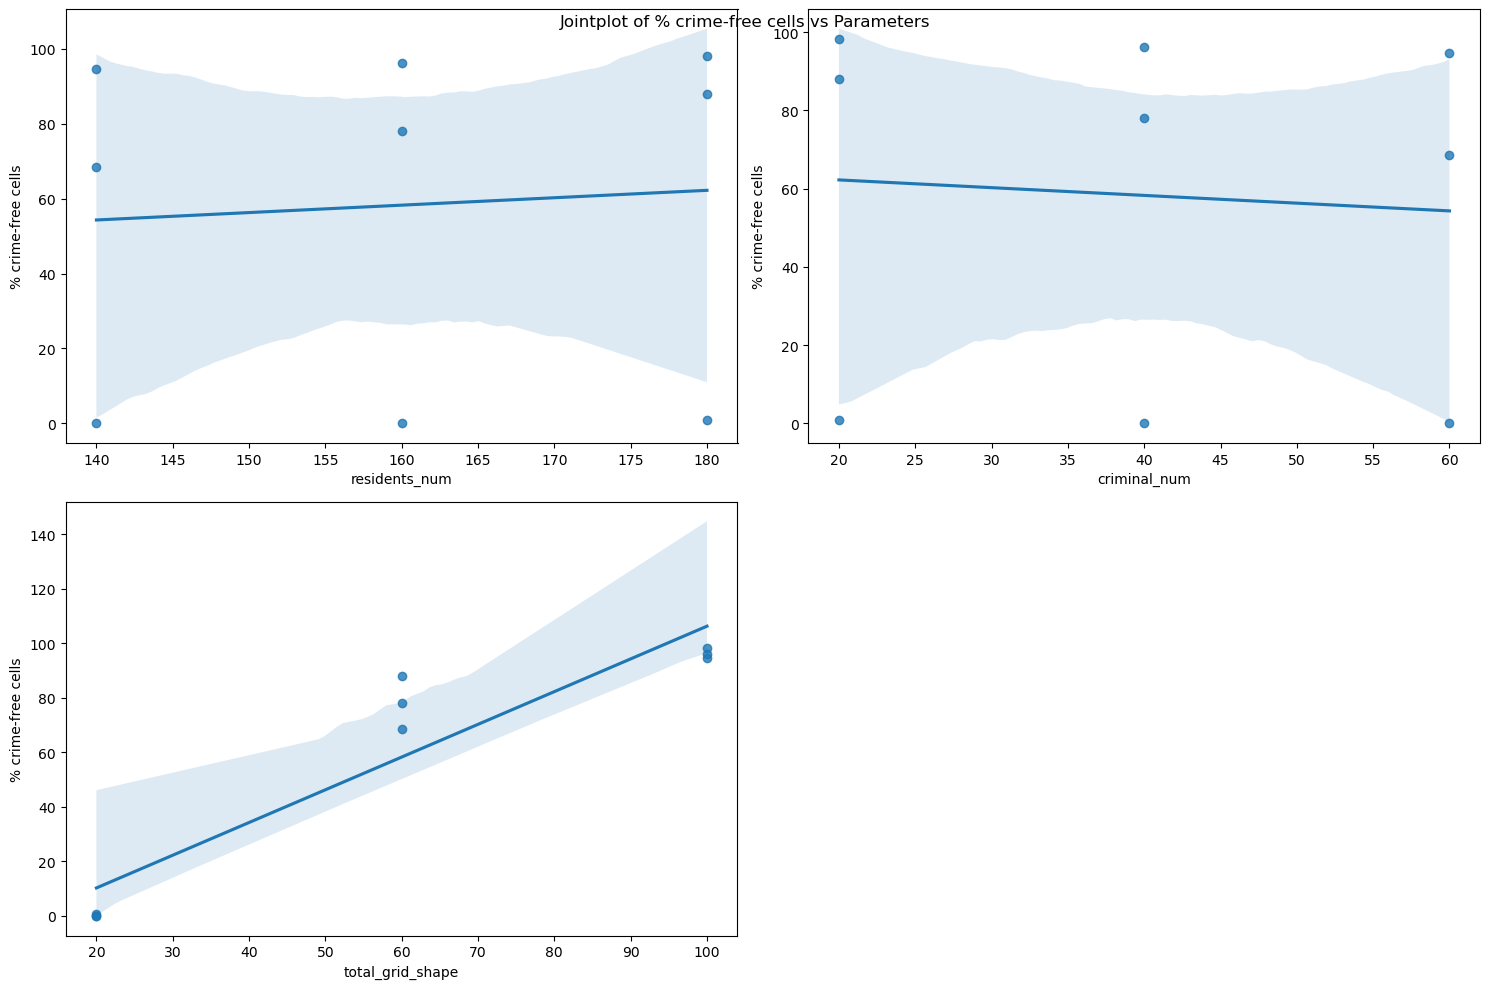

In [11]:
# Jointplot with Grid
for output_var in outcome_vars:
    plt.figure(figsize=(15, 10))
    for i, param in enumerate(input_params):
        plt.subplot(2, 2, i+1)
        sns.regplot(x=param, y=output_var, data=effects)
        plt.xlabel(param)
        plt.ylabel(output_var)
    plt.tight_layout()
    plt.suptitle(f'Jointplot of {output_var} vs Parameters')
    plt.show()


In [12]:
from scipy.stats import linregress

# Perform regression analysis
for output_var in outcome_vars:
    for param in input_params:
        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(effects[param], effects[output_var])
        
        # Print regression results
        print(f"{output_var} vs {param}: R-squared = {r_value**2:.2f}, p-value = {p_value:.4f}")


Total crimes vs residents_num: R-squared = 0.15, p-value = 0.3070
Total crimes vs criminal_num: R-squared = 0.15, p-value = 0.3070
Total crimes vs total_grid_shape: R-squared = 0.63, p-value = 0.0108
Maximum crimes vs residents_num: R-squared = 0.07, p-value = 0.4936
Maximum crimes vs criminal_num: R-squared = 0.07, p-value = 0.4936
Maximum crimes vs total_grid_shape: R-squared = 0.69, p-value = 0.0054
% crime-free cells vs residents_num: R-squared = 0.01, p-value = 0.8437
% crime-free cells vs criminal_num: R-squared = 0.01, p-value = 0.8437
% crime-free cells vs total_grid_shape: R-squared = 0.87, p-value = 0.0002


# Part B

In [14]:
class Cell:
    def __init__(self, x, y): # inputs - coordinates
        self.x = x
        self.y = y
        
        self.agents = [] # stores agents located within the cell
        self.crimes = 0 # tracks the number of crimes committed in the cell


class Agent:
    def __init__(self, a_type, cell, budget):
        '''inputs:
            a_type (str): type of agent - resident/criminal,
            cell (Cell object): cell in which the agent starts the simulation
            budget (int): resources at the disposal of the agent
            '''
        self.a_type = a_type
        self.cell = cell
        self.budget = budget

        # print('Budget init = ', self.budget)
        
        cell.agents.append(self) # locate agent inside the cell
    
    def distance(self, cell):
        '''Computes the distance between the agent's current location and a given cell.
        Inputs: cell - Cell object'''
        dx = self.cell.x - cell.x
        dy = self.cell.y - cell.y
        return (dx**2 + dy**2)**0.5
    
    def resident_step(self):
        '''step method for resident agents - moves to a random new cell'''
        self.budget += 1 # resources increase with every step
        new_cell = self.cell # set current cell as new cell
        while new_cell == self.cell: # loop to make sure a new cell is selected
            new_cell = choice(choice(model.grid)) # randomly choose an array and a cell from the array
        return new_cell
        
    def criminal_utility(self, cell, max_agents, weight):
        '''Computes the utility the agent derives from the input cell, 
        based on distance and number of agents in the cell.
        Inputs: cell (Cell object) - the cell for which to compute utility, 
        max_agents (int) - the maximal number of agents present in one cell (required for normalization)'''
        if self.distance(cell) > self.budget:
            return 0
        else: 
            d_utility = 1-self.distance(cell)/self.budget
            c_utility = len(cell.agents)/max_agents
            utility = weight*c_utility + (1-weight)*d_utility

            return utility
    
    def criminal_step(self, weight):
        '''step method for criminal agents - 
        move to a random cell based on probabilities, randomly select an agent and steal 1 resource point'''
        cells = [model.grid[x][y] for x in range(model.grid_shape[0]) for y in range(model.grid_shape[1]) 
                 if model.grid[x][y] != self.cell] # list all cells but current cell
        max_agents = max([len(c.agents) for c in cells]) # find the maximal number of agents per cell
        utilities = [self.criminal_utility(cell, max_agents, weight) for cell in cells] # compute utility value per cell
        if sum(utilities) > 0: # choices requires that sum of weights would be greater than 0
            new_cell = choices(cells, utilities)[0] # randomly (with weights based on probabilities) choose one cell
        else:
            new_cell = choice(cells) # if sum of weights is zero, choose randmoly without weights
            
        if new_cell.agents: # if there are any agents in the cell (empty list==False)
            agent = choice(new_cell.agents) # randomly choose an agent present in the cell
            if agent.budget > 0: # if the agent has any resources - steal one unit
                agent.budget -= 1 # remove one unit of resources from selected agent
                self.budget += 1 # add one unit to current agent
                new_cell.crimes += 1 # increase the new cell's crime counter
    
        return new_cell
    
    def step(self, weight):
        '''General step method for both types of agents:
            locates new cell and makes the required changes'''
        if self.a_type == 'resident': # check agent type and activate step method
            new_cell = self.resident_step()
        else:
            new_cell = self.criminal_step(weight)
        
        self.cell.agents.remove(self) # remove current agent from current cell
        new_cell.agents.append(self) # add current agent to new cell
        self.cell = new_cell # move current agent to new cell
        

class Model:
    def __init__(self, residents_num, criminal_num, grid_shape, weight):
        '''inputs: residents_num (int) - number of resident agents,
        criminal_num (int) - number of criminal agents,
        grid_shape (container of two int items) - number of grid rows and columns,
        weight - weight parameter of crime factor in utility function'''
        self.grid_shape = grid_shape
        
        # create a 2D array of Cell objects
        self.grid = [[Cell(x, y) for y in range(grid_shape[1])] for x in range(grid_shape[0])] 
        # create a 1d Array of Agent objects  (length==resident_num) located in a random cell and with a random budget
        self.residents = [Agent('resident', choice(choice(self.grid)), randint(10, 50)) for i in range(residents_num)]
        # create a 1d Array of Agent objects  (length==criminal_num) located in a random cell and with budget==1
        self.criminals = [Agent('criminal', choice(choice(self.grid)), 1) for i in range(criminal_num)]

        self.weight = weight
    
    def simulate(self):
        '''Run 30 iterations and return the total number of crimes, maximal number of crimes per cell,
        and percent of cells where no crimes were registered througout the simulation'''
        for i in range(5):
            agents = self.residents + self.criminals # merge the lists of agents into one
            shuffle(agents) # randomly reorder the merged list
            for agent in agents: # execute step function per agent
                agent.step(self.weight)
        
        # generate outputs - get the count of crimes per cell
        crimes = [self.grid[x][y].crimes for x in range(self.grid_shape[0]) for y in range(self.grid_shape[1])]
        total_crimes = sum(crimes) # total number of crimes committed throughout the simulation
        max_crimes = max(crimes) # get the counter value for the cell with the most crimes committed
        # compute the percent of cells where no crime was committed
        no_crimes = 100 * len([c for c in crimes if c==0]) / (self.grid_shape[0] * self.grid_shape[1])
        return (total_crimes, max_crimes, no_crimes)

        

model = Model(180, 20, (30, 30), 0.5)
model.simulate()


(45, 2, 95.33333333333333)

In [15]:
params = pd.read_csv("parameters_B.csv")
params = params.reset_index(drop=True)

outputs_avg = pd.DataFrame(columns = {
    'Total crimes':[],
    'Maximum crimes':[],
    '% crime-free cells':[]
})


for param, row in params.iterrows():
    residents_num, criminal_num, grid_shape1, grid_shape2, weight = map(int, row[:5])
    results = []

    for sim in range(5):
        model = Model(residents_num, criminal_num, (grid_shape1, grid_shape2), weight)
        sim_results = model.simulate()
        results.append(sim_results)

    averages = np.mean(results, axis=0)
    outputs_avg.loc[len(outputs_avg)] = averages

effects = pd.concat([params, outputs_avg], axis=1)




In [16]:
effects = pd.concat([params, outputs_avg], axis=1)

# replace string in the below function with a folder and file name for your PC

# Remove extra space from column names
effects.columns = effects.columns.str.strip()

# Combine the two grid_shape columns into a new column
effects['total_grid_shape'] = effects['grid_shape1'] + effects['grid_shape2']

# drop old grid shape columns 
effects.drop(columns=['grid_shape1', 'grid_shape2'], inplace=True)

print(effects)
#effects.to_csv('effects_B.csv')

   residents_num  criminal_num  weight  Total crimes  Maximum crimes  \
0            180            20    0.25          19.8             1.6   
1            180            20    0.50          21.0             1.8   
2            180            20    0.75          20.0             1.4   
3            160            40    0.25          36.8             1.8   
4            160            40    0.50          39.2             2.2   
5            160            40    0.75          41.8             2.2   
6            140            60    0.25          64.8             2.6   
7            140            60    0.50          57.8             2.4   
8            140            60    0.75          61.0             2.8   

   % crime-free cells  total_grid_shape  
0           97.866667                60  
1           97.755556                60  
2           97.822222                60  
3           96.044444                60  
4           95.911111                60  
5           95.622222      

In [19]:
# Define the input parameters and outcome variables
input_params = ['residents_num', 'criminal_num', 'weight']
outcome_vars = ['Total crimes', 'Maximum crimes', '% crime-free cells']

# Print the first few rows of the DataFrame
print(effects.head())


   residents_num  criminal_num  weight  Total crimes  Maximum crimes  \
0            180            20    0.25          19.8             1.6   
1            180            20    0.50          21.0             1.8   
2            180            20    0.75          20.0             1.4   
3            160            40    0.25          36.8             1.8   
4            160            40    0.50          39.2             2.2   

   % crime-free cells  total_grid_shape  
0           97.866667                60  
1           97.755556                60  
2           97.822222                60  
3           96.044444                60  
4           95.911111                60  


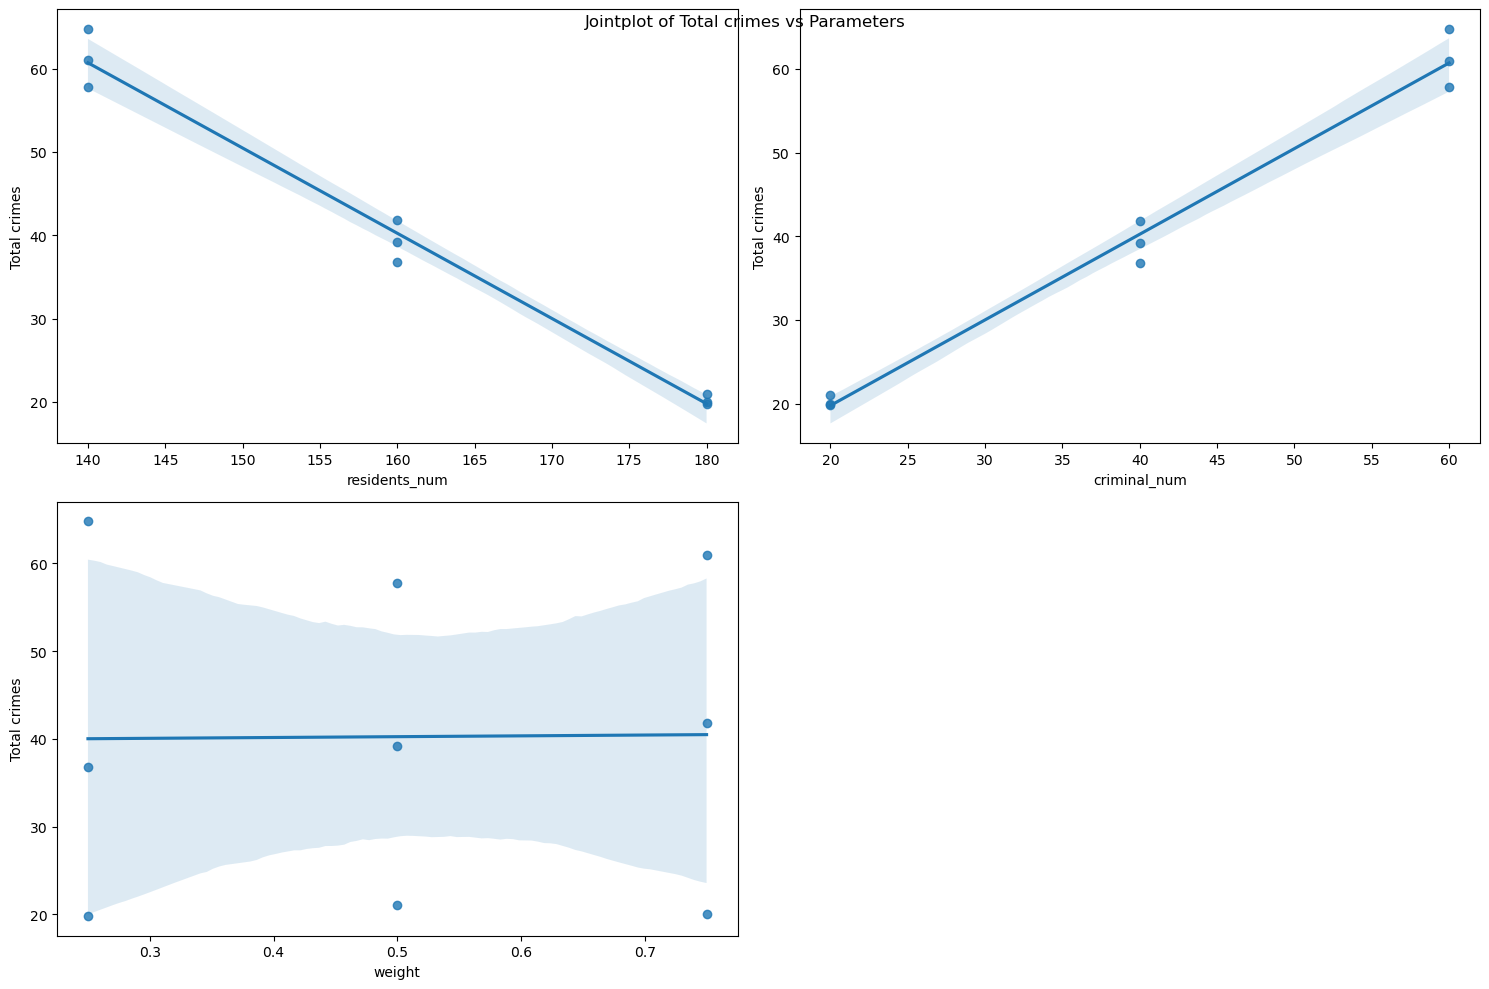

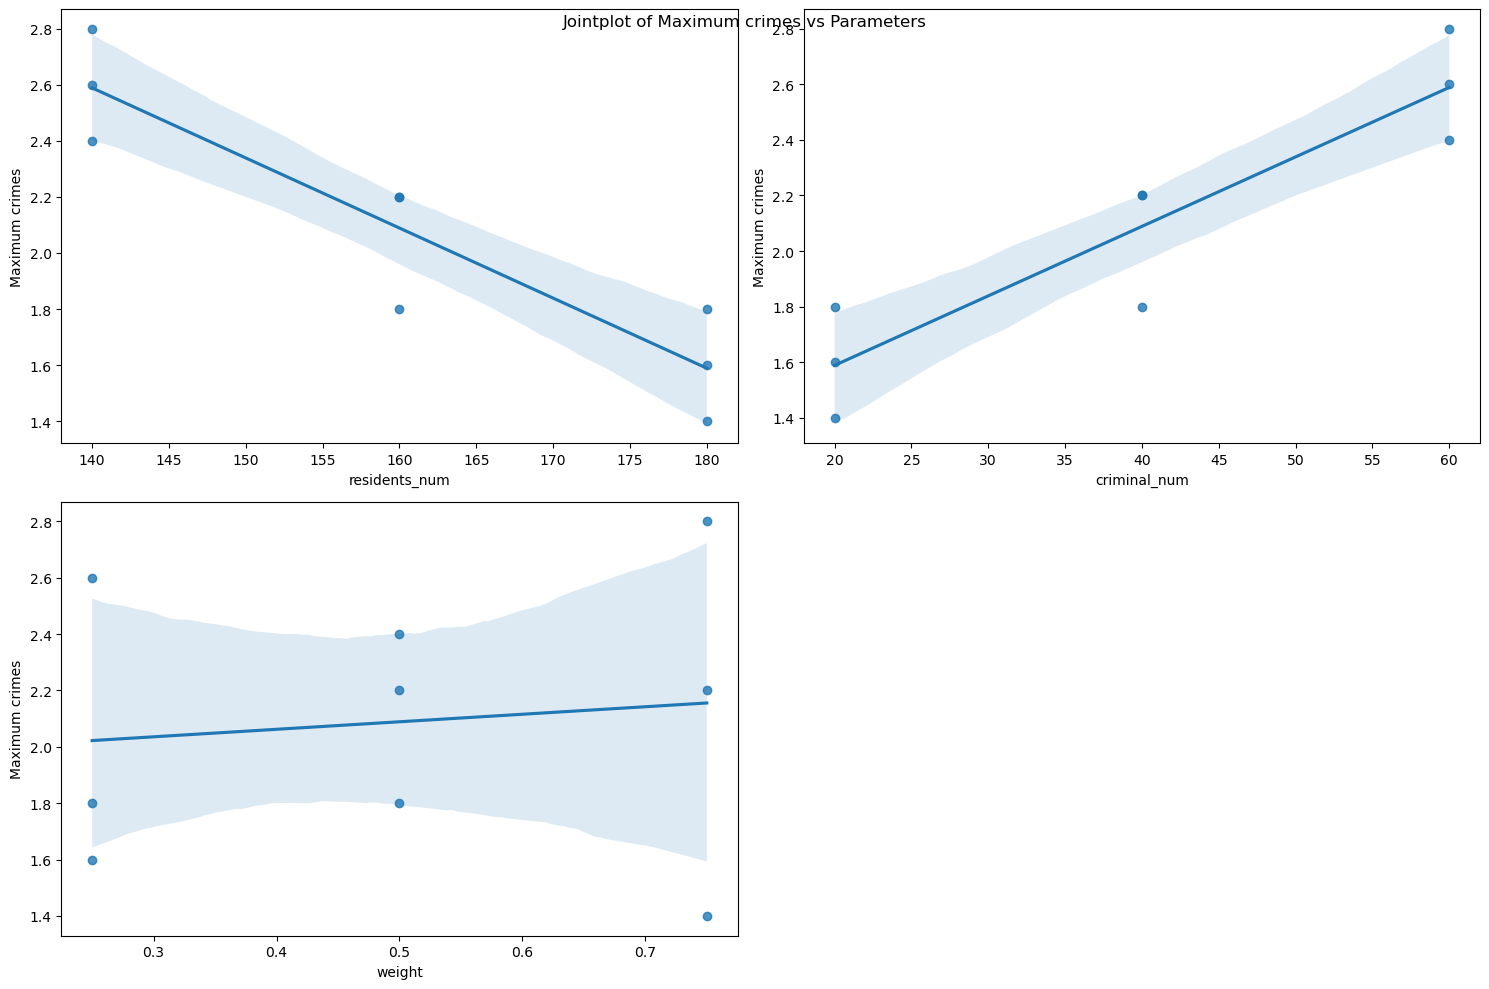

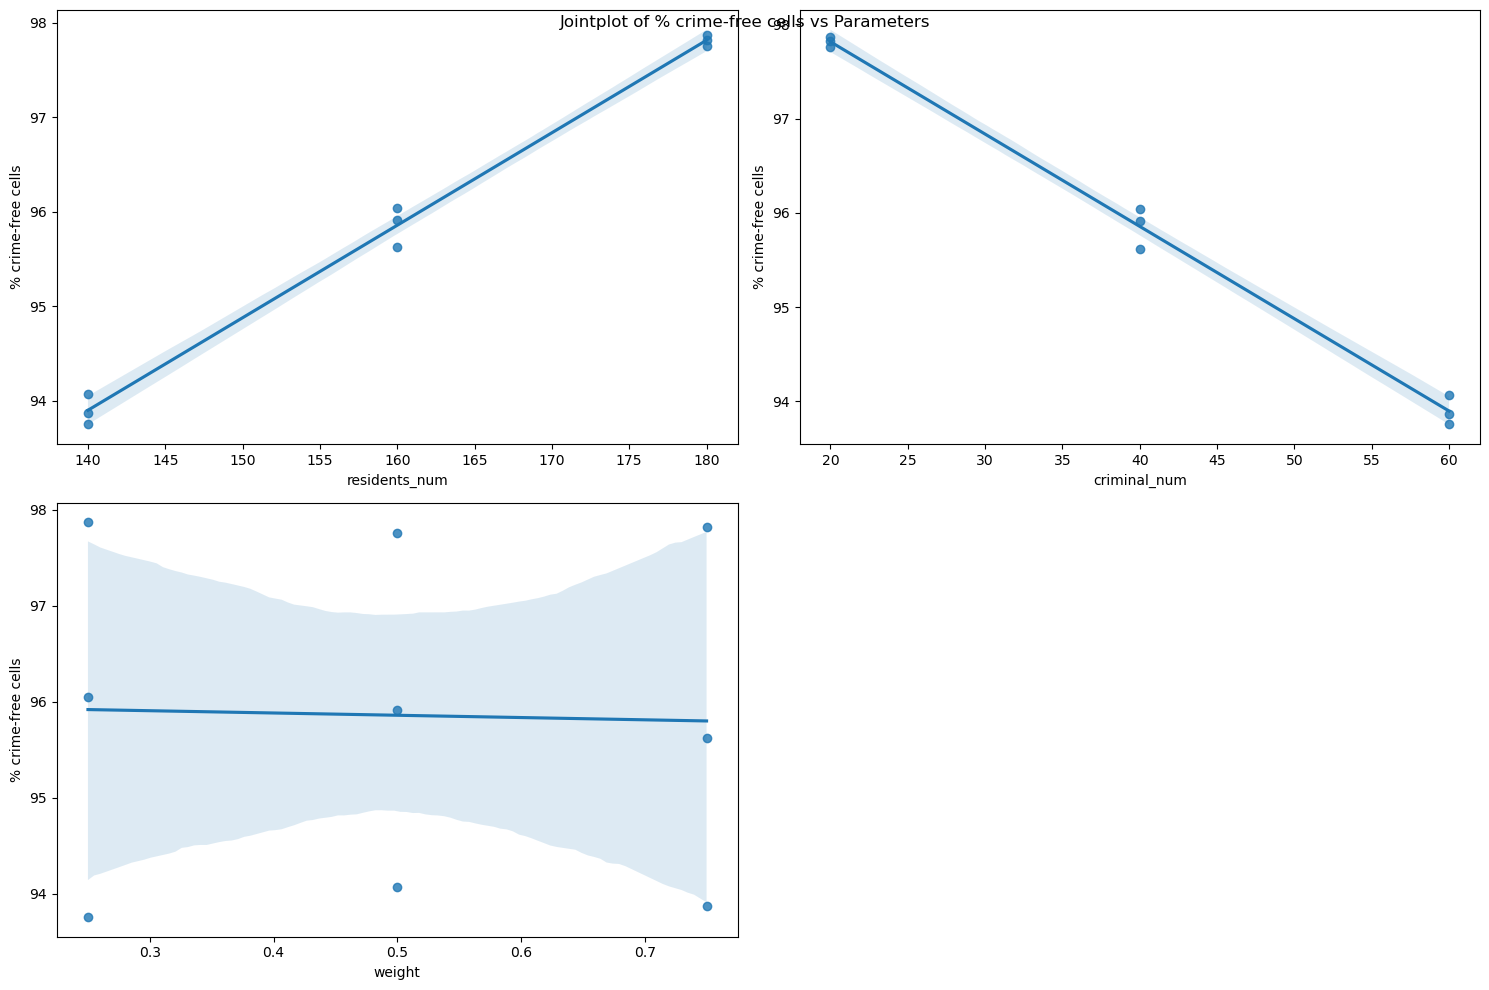

In [20]:
# Jointplot with Grid
for output_var in outcome_vars:
    plt.figure(figsize=(15, 10))
    for i, param in enumerate(input_params):
        plt.subplot(2, 2, i+1)
        sns.regplot(x=param, y=output_var, data=effects)
        plt.xlabel(param)
        plt.ylabel(output_var)
    plt.tight_layout()
    plt.suptitle(f'Jointplot of {output_var} vs Parameters')
    plt.show()


In [21]:
import pandas as pd
from scipy.stats import linregress
from IPython.display import display

# Initialize an empty DataFrame to store regression results
regression_df = pd.DataFrame()

# Perform regression analysis
for output_var in outcome_vars:
    for param in input_params:
        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(effects[param], effects[output_var])
        
        # Store regression results in a DataFrame
        result = pd.DataFrame({
            'Input Parameter': [param],
            'Output Variable': [output_var],
            'R-squared': [r_value**2],
            'p-value': [p_value]
        })
        
        # Append DataFrame to the main DataFrame
        regression_df = pd.concat([regression_df, result])

# Pivot the DataFrame
regression_df = regression_df.pivot(index='Output Variable', columns='Input Parameter')

# Rename the index and reset the columns
regression_df.index.name = None
regression_df.columns = [f'{col[1]} ({col[0]})' for col in regression_df.columns]

# Display the DataFrame as an interactive table
display(regression_df)


,criminal_num (R-squared),residents_num (R-squared),weight (R-squared),criminal_num (p-value),residents_num (p-value),weight (p-value)
% crime-free cells,0.993565,0.993565,0.000909,6.235236e-09,6.235236e-09,0.938629
Maximum crimes,0.847990,0.847990,0.015075,4.245767e-04,4.245767e-04,0.752992
Total crimes,0.983488,0.983488,0.000128,1.694364e-07,1.694364e-07,0.976970


In [22]:
from scipy.stats import linregress

# Perform regression analysis
for output_var in outcome_vars:
    for param in input_params:
        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(effects[param], effects[output_var])
        
        # Print regression results
        print(f"{output_var} vs {param}: R-squared = {r_value**2:.2f}, p-value = {p_value:.4f}")


Total crimes vs residents_num: R-squared = 0.98, p-value = 0.0000
Total crimes vs criminal_num: R-squared = 0.98, p-value = 0.0000
Total crimes vs weight: R-squared = 0.00, p-value = 0.9770
Maximum crimes vs residents_num: R-squared = 0.85, p-value = 0.0004
Maximum crimes vs criminal_num: R-squared = 0.85, p-value = 0.0004
Maximum crimes vs weight: R-squared = 0.02, p-value = 0.7530
% crime-free cells vs residents_num: R-squared = 0.99, p-value = 0.0000
% crime-free cells vs criminal_num: R-squared = 0.99, p-value = 0.0000
% crime-free cells vs weight: R-squared = 0.00, p-value = 0.9386
